# Remaining Useful Life Estimation

In this notebook, we build a machine learning model to predict remaining useful life (RUL) for jet engines.

## Install and import necessary libraries

Load necessary libraries, and optionally install missing requirements.  If any other needed libraries are not installed, please install them with `!pip install <library name>`.

In [12]:
# Uncomment the following two lines to install seaborn and matplotlib (if not already installed)
# !pip install seaborn
# !pip install matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from nyoka import skl_to_pmml

## Load data

We load 3 data files which describe the operation of turbofan engines with one operating condition (sea level) and one fault mode (high-pressure compressor degradation). The training set (train_df) contains data for 100 engines, each of which runs until failure. The test set (test_df) describes 100 engines as well, but the data ends sometime before failure. The third dataset (y_test) contains true RUL values for the last time cycle of each engine in the test set.

In [ ]:
data_dir = '../Data/'

sensors = ['s_{}'.format(i) for i in range(1,22)] 
cols = ['unit', 'cycle', 'set_1', 'set_2', 'set_3'] + sensors

train_df = pd.read_csv((data_dir + 'train_FD001.csv'), sep=',')
test_df = pd.read_csv((data_dir + 'test_FD001.csv'), sep=',')
y_test = pd.read_csv((data_dir + 'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

print(train_df.head(3))
print(test_df.head(3))
print(y_test.head(5))

   unit  cycle   set_1   set_2  set_3     s_1     s_2      s_3      s_4  \
0     1      1 -0.0007 -0.0004    100  518.67  641.82  1589.70  1400.60   
1     1      2  0.0019 -0.0003    100  518.67  642.15  1591.82  1403.14   
2     1      3 -0.0043  0.0003    100  518.67  642.35  1587.99  1404.20   

     s_5  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  s_19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03   392  2388   100   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03   392  2388   100   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03   390  2388   100   

    s_20     s_21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.95  23.3442  

[3 rows x 26 columns]
   unit  cycle   set_1   set_2  set_3     s_1     s_2      s_3      s_4  \
0     1      1  0.0023  0.0003    100  518.67  643.02  1585.29  1398.21   
1     1      2 -0.0027 -0.0003    100  518.67  641.71  1588.45  1395.42   
2     1      3  0.0003  0.0001    100  518.67  642.46  1586.94  1401.3

## Exploratory data analysis

In this section, we explore the training data to gain a better understanding of its properties.

(20631, 26)
unit
1    192
2    287
3    179
4    189
5    269
Name: cycle, dtype: int64
         count         mean           std        min        25%        50%  \
unit   20631.0    51.506568  2.922763e+01     1.0000    26.0000    52.0000   
cycle  20631.0   108.807862  6.888099e+01     1.0000    52.0000   104.0000   
set_1  20631.0    -0.000009  2.187313e-03    -0.0087    -0.0015     0.0000   
set_2  20631.0     0.000002  2.930621e-04    -0.0006    -0.0002     0.0000   
set_3  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_1    20631.0   518.670000  0.000000e+00   518.6700   518.6700   518.6700   
s_2    20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3    20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4    20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5    20631.0    14.620000  1.776400e-15    14.6200    14.6200    14.6200   
s_6    20631.0    21.609803  1.388985e-03    21.6000  

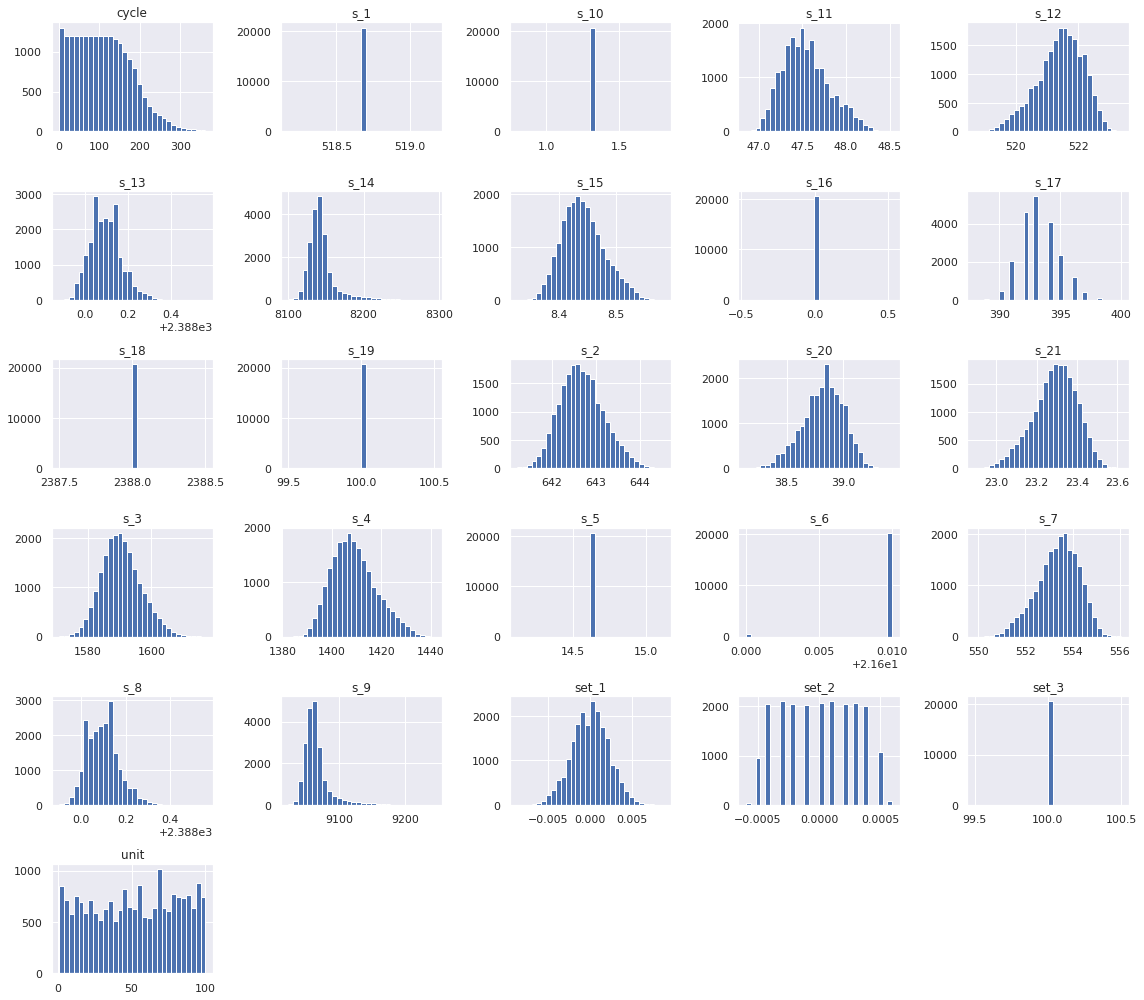

In [5]:
# print data shape
print(train_df.shape)

# print a few max cycle values
print(train_df.groupby('unit')['cycle'].max().head(5))

# print data stats
print(train_df.describe().transpose())

# print feature histograms
sns.set(font_scale=1) 
train_df.hist(bins=30, figsize=(16,14), color='b')
plt.tight_layout()
plt.show()

The data consists of columns for engine unit and time cycle, 3 operational setting columns (set_1 - set_3), and 24 sensors. We see that there are 20631 rows, and that each engine lasts a different number of cycles before failure. The settings columns have very small standard deviations since there is only one operational condition; these features would not be useful for modeling. This is also the case for sensors 1, 5, 6, 10, 16, 18 and 19, which have either 0 or close to 0 standard deviations. 

## Add RUL target variable and finalize datasets

We now create the target variable (remaining useful life) to the training dataset. The approach used here assumes that RUL decreases linearly with each cycle - that is, RUL is measured in cycles, and reaches 0 at the last cycle for each engine at failure. We see this linear decrease when printing out a few rows for units 1 and 5.

In [6]:
max_time_cycle=train_df.groupby('unit')['cycle'].max()

rul = pd.DataFrame(max_time_cycle).reset_index()
rul.columns = ['unit', 'max']
rul.head()

train_df = train_df.merge(rul, on=['unit'], how='left')

train_df['RUL'] = train_df['max'] - train_df['cycle']

train_df.drop('max', axis=1, inplace=True)

# print examples for units 1 and 5
print(train_df[train_df.unit==1].iloc[:,[1,-1]])
print(train_df[train_df.unit==5].iloc[:,[1,-1]])

     cycle  RUL
0        1  191
1        2  190
2        3  189
3        4  188
4        5  187
..     ...  ...
187    188    4
188    189    3
189    190    2
190    191    1
191    192    0

[192 rows x 2 columns]
      cycle  RUL
847       1  268
848       2  267
849       3  266
850       4  265
851       5  264
...     ...  ...
1111    265    4
1112    266    3
1113    267    2
1114    268    1
1115    269    0

[269 rows x 2 columns]


We finalize the train and test datasets by dropping features that won't be useful for modeling, and creating a separate target array for the training set. For the test set, we drop all rows except the final row for each engine, since y_test only contains true RUL values for the last time cycle of each engine.

In [7]:
sensors_drop = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
labels_drop = ['unit', 'cycle', 'set_1', 'set_2', 'set_3'] + sensors_drop
X_train = train_df.drop(labels_drop + sensors_drop, axis=1)
y_train = X_train.pop('RUL')

X_test = test_df.groupby('unit').last().reset_index().drop(labels_drop + sensors_drop, axis=1)

print(X_train.columns)
print(X_test.columns)

Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13',
       's_14', 's_15', 's_17', 's_20', 's_21'],
      dtype='object')
Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13',
       's_14', 's_15', 's_17', 's_20', 's_21'],
      dtype='object')


## Train model and check performance

We now build a model using the training data. We are using a random forest regressor, and since it is a random forest, it is not necessary to normalize the features.

In [8]:
pipeline_obj = Pipeline([
    ('rf',RandomForestRegressor(n_estimators = 100,
                                max_features = "sqrt",
                                max_depth = 10,
                                min_samples_leaf = 50,
                                random_state = 11))
])

pipeline_obj.fit(X_train, y_train)

y_hat_train = pipeline_obj.predict(X_train)
y_hat_test = pipeline_obj.predict(X_test)

print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_hat_train)):0.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_hat_test)):0.4f}")

distutils Version classes are deprecated. Use packaging.version instead.
distutils Version classes are deprecated. Use packaging.version instead.


Train RMSE: 39.9627
Test RMSE: 30.6372


distutils Version classes are deprecated. Use packaging.version instead.
distutils Version classes are deprecated. Use packaging.version instead.


In [9]:
print(y_hat_train)
print(y_hat_test)

[165.27845263 161.79757803 169.73293501 ...   5.64457784   5.55870302
   4.01796242]
[165.97573448 136.31401183  59.47744331 104.9974686  116.39340335
 131.24056938 120.58935267 100.72346765 126.95654073 130.78838855
  64.58956662  93.63341673 105.82191299 126.03886996 168.80880773
 134.3077848   57.62946852  74.48279813 137.08568959  25.64357132
  75.96453523 151.7804015  164.83385635  38.81778426 154.03120322
 128.3985362  143.58905316 110.41795037 116.514356   113.08778818
  22.13988447  62.58654774 103.83715512   7.01283409   8.52650212
  25.23636326  56.86271939  51.78557606 154.84525267  30.19450174
  78.44534385  22.06258206  74.65653679 124.94778852  86.58775361
  49.73478556 136.71016545 133.99218015  13.65452995 129.43462337
 136.57112749  41.62523838  36.6805884  168.38923681 152.75127252
  16.53575166 114.71673304  59.7816735  168.74689131 133.91072432
  43.37564281  56.22476497  67.86643639  52.00853262 165.46343556
  17.1465901  146.19746091  17.21825718 144.06001637 124.

## Export to PMML

Finally, we use the nyoka library to export and save the model to PMML.

In [11]:
features = X_train.columns
target = 'RUL'

skl_to_pmml(pipeline = pipeline_obj,
            col_names = features,
            target_name = target,
            pmml_f_name = "../Model/RUL_rf.pmml",
            model_name = "RULRFRegressor")